In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_trial_type_FIGURES'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [5]:
# use `save_worspace(db)` to save variables at the end
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42

In [6]:
#mmc = multiple-comparisons correction (using bonferroni), where mcc = number of comparisons))

from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1,suppress_ns=True):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_ind(x,y)
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    if suppress_ns==True:
        if p <= thresholds[0]/mcc:
            line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
            ax.add_line(line)
            ax.text(np.mean([x1, x2]), y,
                    '*' if p > thresholds[1]/mcc else
                    '**' if p > thresholds[2]/mcc else
                    '***',
                    ha='center', fontsize=5)
    else:
        line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
        ax.add_line(line)
        ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p > thresholds[0]/mcc else
            '*' if p > thresholds[1]/mcc else
            '**' if p > thresholds[2]/mcc else
            '***',
            ha='center', fontsize=5)
    return sig_value, p

In [7]:
#mmc = multiple-comparisons correction (using bonferroni), where mcc = number of comparisons))

from matplotlib.lines import Line2D
def add_significance_point(ax, array1, array2, x1, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),
                                   mcc=1,color='k',symbol='*'):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    #line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    #ax.add_line(line)
    ax.text(x1, y,
            "" if p > thresholds[0]/mcc else
            symbol if p > thresholds[1]/mcc else
            symbol+symbol if p > thresholds[2]/mcc else
            symbol+symbol+symbol,
            #symbol if p < thresholds[1]/mcc else
            #"",
            ha='center', fontsize=5,color=color)
    return sig_value, p

In [8]:
def report_stats (array1, array2, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
        U = sig_func(array1, array2)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        p = sig_func(array1, array2)[-1]
        print "U =",U,"p =",p*mcc,"r =",r
    if sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_ind(x, y)
        cohens_d = (np.mean(array1)-np.mean(array2))/np.sqrt((np.std(array1)**2+np.std(array2)**2)/2)
        p = sig_func(array1, array2)[-1]
        print sig_func(array1, array2),"d =", cohens_d, 'corrected p =',p*mcc
    if sig_func is 'fishers':
        table = array1,array2
        sig_func = lambda x: sstats.fisher_exact(x, alternative='two-sided')
        p = sig_func(table)[-1]
        odds_ratio = sig_func(table)[0]
        print sig_func(table),"odd's ratio =", odds_ratio, 'corrected p =',p*mcc
        

def report_stats_chance (array1, chance=0.5, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        U = sig_func(subtracted)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        print sig_func(subtracted),"r =",r
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        cohens_d = (np.mean(array1)-chance)/np.std(array1)
        print sig_func(array1,chance),"d =",cohens_d

In [11]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=10, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [12]:
delta_t05s = 0.5
t_start05s = -3
t_stop05s  = 11.5

delta_t1s = 1
t_start1s = -3  # sec
t_stop1s  = 11  # sec

delta_t2s = 2
t_start2s = -2
t_stop2s  = 10

#1sec time bins centered on the half-second
delta_t15s = 1
t_start15s = -3.5  # sec
t_stop15s = 10.5  # sec

In [13]:
sessions = 'post',
bins = ['05s','1s','2s']
bin_ranges=[]
for tb in bins:
    if tb == '05s':
        div=0.5
    else:
        div=tb[:-1]
            #print range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
    #for t in range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div)))):
    bin_ranges.append(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
print bin_ranges

[29, 14, 6]


In [14]:
#trial type labels:
#reward w/o eliciting sucrose = 1, rew eliciting reward but not collecting within 1.5s of delivery=+ = 4, rew w/ consumption = 5
#CSm w/o running > threshold= 2, CSm w/ running > threshold = 6
#AA shocked= 3, AA avoided shock (running > threshold) = 7

In [15]:
#time bins for each tb delta to use for baseline (05s starts at -2s, 1s at -2s, 2s at -2s)

In [69]:
#import results from notebooks
comparisons=['consumed','run_CSm'],['consumed','run_AA'],['run_CSm','run_AA'],['still_rew','still_CSm'],\
['still_rew','still_AA'],['still_CSm','still_AA'],['still_rew','consumed'],['still_CSm','run_CSm'],['still_AA','run_AA']
for tb,i in zip(bins,range(len(bins))):
    for t in range(bin_ranges[i]): # number of time bins
        for comp in comparisons:
            for reg in 'dhpc','vhpc':
                for score in '','gmin_','gmins_','gmins_HP_','gmins_speed_':
                    exec("scores_%s%s_%s_%s_vs_%s_%s = {}"%(score,tb,t,comp[0],comp[1],reg))
                    for sess in 'post':
                        try:
                            exec("scores_%s%s_%s_%s_vs_%s_%s = ut.load_variable\
                              ('scores_%s%s_%s_%s_vs_%s','../notebooks/autorestore/decoding_trial_type_%s')"\
                              %(score,tb,t,comp[0],comp[1],reg,score,tb,t,comp[0],comp[1],reg))
                        except: print "NOPE",reg,score,comp,"   ",

NOPE dhpc gmins_speed_ ['still_rew', 'still_CSm']     NOPE dhpc gmins_speed_ ['still_rew', 'still_CSm']     NOPE dhpc gmins_speed_ ['still_rew', 'still_CSm']     NOPE dhpc gmins_speed_ ['still_rew', 'still_CSm']     NOPE vhpc gmins_speed_ ['still_rew', 'still_CSm']     NOPE vhpc gmins_speed_ ['still_rew', 'still_CSm']     NOPE vhpc gmins_speed_ ['still_rew', 'still_CSm']     NOPE vhpc gmins_speed_ ['still_rew', 'still_CSm']     NOPE dhpc gmins_speed_ ['still_rew', 'still_AA']     NOPE dhpc gmins_speed_ ['still_rew', 'still_AA']     NOPE dhpc gmins_speed_ ['still_rew', 'still_AA']     NOPE dhpc gmins_speed_ ['still_rew', 'still_AA']     NOPE vhpc gmins_speed_ ['still_rew', 'still_AA']     NOPE vhpc gmins_speed_ ['still_rew', 'still_AA']     NOPE vhpc gmins_speed_ ['still_rew', 'still_AA']     NOPE vhpc gmins_speed_ ['still_rew', 'still_AA']     NOPE dhpc gmins_speed_ ['still_CSm', 'still_AA']     NOPE dhpc gmins_speed_ ['still_CSm', 'still_AA']     NOPE dhpc gmins_speed_ ['still_CSm', '

In [110]:
%%time
#get train and test subsamples for each timebin, for each session
speed_comparisons='still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA'
for tb,i in zip(bins,range(len(bins))):
    for t in range(bin_ranges[i]): # number of time bins
        for comp in speed_comparisons:
            for reg in 'dhpc','vhpc':
                exec('speed_scores_gmin_%s_%s_%s_%s = {}'%(tb,t,comp,reg))
                exec('late_speed_scores_gmin_%s_%s_%s_%s = {}'%(tb,t,comp,reg))
                for sess in 'post',:
                    try:
                        exec("speed_scores_gmin_%s_%s_%s_%s= ut.load_variable\
                              ('speed_scores_gmin_%s_%s_%s','../notebooks/autorestore/decoding_trial_type_%s')"\
                              %(tb,t,comp,reg,tb,t,comp,reg))
                    except: print "NOPE",reg,comp,"speed   ",
                    try:
                        exec("late_speed_scores_gmin_%s_%s_%s_%s= ut.load_variable\
                              ('late_speed_scores_gmin_%s_%s_%s','../notebooks/autorestore/decoding_trial_type_%s')"\
                              %(tb,t,comp,reg,tb,t,comp,reg))
                    except: print "NOPE",reg,comp,"late_speed   ",

CPU times: user 300 ms, sys: 264 ms, total: 564 ms
Wall time: 870 ms


#No longer necessary since I have functions to do this now
loops=10
comparisons=['consumed','run_CSm'],['consumed','run_AA'],['run_CSm','run_AA'],['still_rew','still_CSm'],\
['still_rew','still_AA'],['still_CSm','still_AA'],['still_rew','consumed'],['still_CSm','run_CSm'],['still_AA','run_AA']
for tb,i in zip(bins,range(len(bins))):
    for t in range(bin_ranges[i]): # number of time bins
        for comp in comparisons:
            for reg in 'dhpc','vhpc':
                for score in '','gmin_','gmins_','gmins_HP_','gmins_speed_':
                    exec("ttest_tb_%s_%s_%s = {}"%(tb,t,comp_la))
                    exec("mannwhitU_tb_%s_%s_%s = {}"%(tb,t,comp_la))
                    for sess in sessions:
                        exec("ttest_tb_%s_%s_%s[sess] = sstats.ttest_ind(scores_gmin_%s_%s_%s_dhpc[sess][-loops:],\
                           scores_gmin_%s_%s_%s_vhpc[sess][-loops:])"%(tb,t,comp_la,tb,t,comp_la,tb,t,comp_la))
                        exec("mannwhitU_tb_%s_%s_%s[sess] = sstats.mannwhitneyu(scores_gmin_%s_%s_%s_dhpc[sess][-loops:],\
                           scores_gmin_%s_%s_%s_vhpc[sess][-loops:])"%(tb,t,comp_la,tb,t,comp_la,tb,t,comp_la))

In [41]:
np.mean(scores_gmins_1s_3_run_CSm_vs_run_AA_vhpc['post'])

0.99375000000000002

In [ ]:
##################################
###################################
#dont forget to average decoding directions####
#########################################
########################################

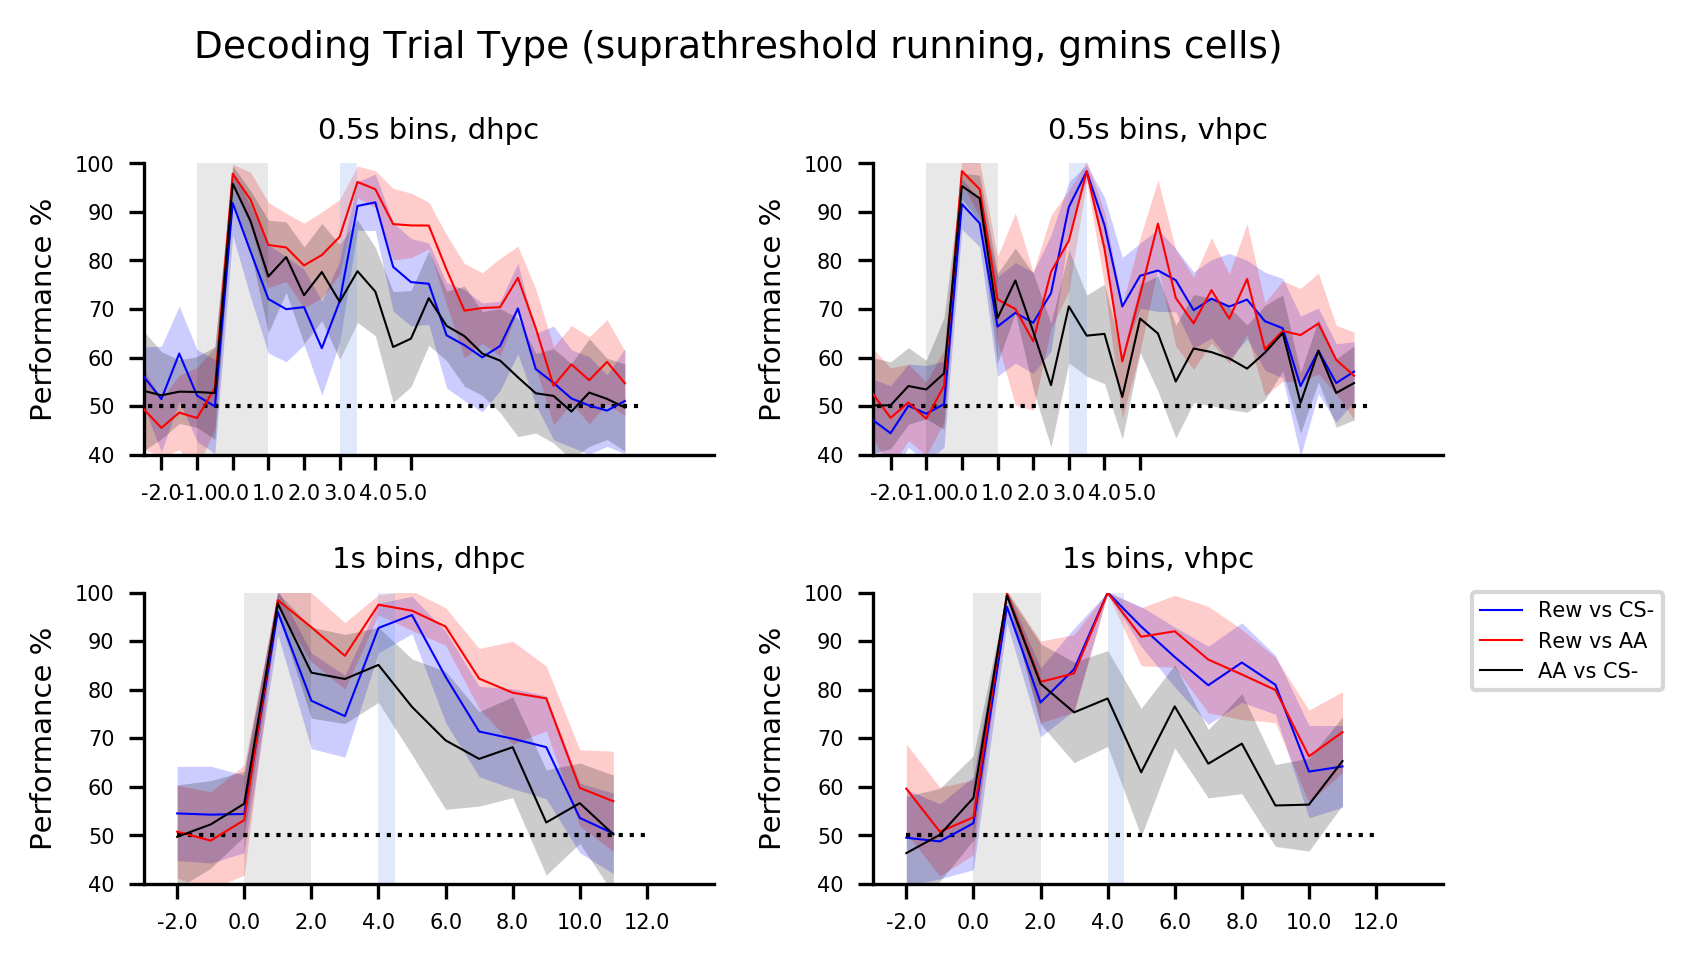

In [79]:
fig, ax = pl.subplots(2,2, figsize=(5,3))

for comp,c,la in zip(['consumed_vs_run_CSm','consumed_vs_run_AA','run_CSm_vs_run_AA'],['b','r','k'],
                     ['Rew vs CS-','Rew vs AA','AA vs CS-']):
    for r,tb,sub in zip(range(2),bins[:2],[4,2]):
        for y, reg in zip([0,1],['dhpc','vhpc']):
            ax[r][y].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("scores_gmins_%s_%s_%s_%s['post']"%(tb,t,comp,reg)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("scores_gmins_%s_%s_%s_%s['post']"%(tb,t,comp,reg)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(np.mean(eval("scores_gmins_%s_%s_%s_%s['post']"%(tb,t,comp,reg)),1))*100 for t in range(bin_ranges[r])])
            ax[r][y].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x,tick in zip(range(2),[2,1]):
    for y,reg in zip([0,1],['dhpc','vhpc']):
        ax[x][y].set_ylim(40, 100)
        ax[x][y].set_xlim(-3, bin_ranges[x])
        ax[x][y].set_xticks(np.arange(-2,13, 2.0))
        ax[x][y].set_xticklabels(np.arange(-2,13*tick, 2.0/tick))
        ax[x][y].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
        #ax[x][y].set_xlabel('Time from odor onset (s)')
        ax[x][y].set_ylabel('Performance %')
        pt.plot_period_bar(ax[x][y], 0, start_end=(0, 2*tick), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[x][y], 0, start_end=(4*tick, 4.5*tick), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[x][y].tick_params(
        #axis='x',          # changes apply to the x-axis
        #which='both',      # both major and minor ticks are affected
        #bottom=False,      # ticks along the bottom edge are off
        #top=False,         # ticks along the top edge are off
        #labelbottom=False) # labels along the bottom edge are off
        ax[0][y].set_title('0.5s bins, %s'%reg, color='k')
        ax[1][y].set_title('1s bins, %s'%reg, color = 'k')
        ax[1][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding Trial Type (suprathreshold running, gmins cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#[y]fig.savefig('../figures/%s_run_gmins.jpg'%NOTEBOOK_NAME)

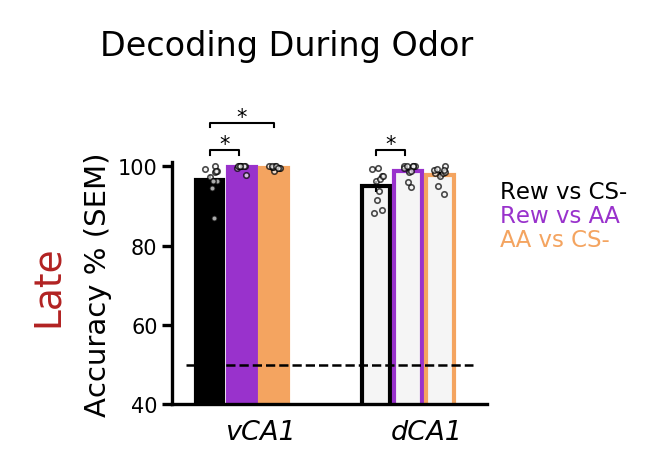

In [92]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
to_plot = [0,1]
t=3
tb='1s'
fig, ax = pl.subplots(figsize=(1.7,1.3))

for comp,c,la,wide in zip(['consumed_vs_run_CSm','consumed_vs_run_AA','run_CSm_vs_run_AA'],['k','darkorchid','sandybrown'],
                     ['Rew vs CS-','Rew vs AA','AA vs CS-'],[-width/3-.25,0,width/3+.25,0.5+.2]):
    ste = np.array(np.std(np.mean(eval("scores_gmins_%s_%s_%s_vhpc['post'][-loops:]"%(tb,t,comp)),1))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("scores_gmins_%s_%s_%s_vhpc['post'][-loops:]"%(tb,t,comp)))*100,
           width, edgecolor=c,color=c,yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, np.mean(eval("scores_gmins_%s_%s_%s_vhpc['post'][-loops:]"%(tb,t,comp)),1)*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
    
for comp,c,la,wide in zip(['consumed_vs_run_CSm','consumed_vs_run_AA','run_CSm_vs_run_AA'],['k','darkorchid','sandybrown'],
                     ['Rew vs CS-','Rew vs AA','AA vs CS-'],[1.8+-width/3-.25,1.8+0,1.8+width/3+.25,1.8+0.5+.2]):
    ste = np.array(np.std(np.mean(eval("scores_gmins_%s_%s_%s_dhpc['post'][-loops:]"%(tb,t,comp)),1))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("scores_gmins_%s_%s_%s_dhpc['post'][-loops:]"%(tb,t,comp)))*100,
           width, edgecolor=c,color='whitesmoke',yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, np.mean(eval("scores_gmins_%s_%s_%s_dhpc['post'][-loops:]"%(tb,t,comp)),1)*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,2.5, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)',labelpad=1.5)
#ax.set_title('Decoding During CS')
ax.set_ylim(40,101)
ax.set_xticks([0.2,2])
ax.set_xticklabels(labels,fontstyle='italic',fontsize=6.5)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.text(2.8,92,'Rew vs CS-',color='k',fontsize=5.5)
ax.text(2.8,86,'Rew vs AA',color='darkorchid',fontsize=5.5)
ax.text(2.8,80,'AA vs CS-',color='sandybrown',fontsize=5.5)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
test='ttest'
for reg,i in zip(['vhpc','dhpc'], [0,1.8]):
    pvs.append(add_significance(ax,np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),1),
                                np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
                                -width/3-.25+i,i-.03,104,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
                                np.mean(eval("scores_gmins_%s_%s_run_CSm_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
        i+.03,width/3+.25+i,104,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),1),
                                np.mean(eval("scores_gmins_%s_%s_run_CSm_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
        -width/3-.25+i,width/3+.25+i,111,sig_func=test,mcc=2))
    #print reg,'rw/sh',report_stats(eval("scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("scores_tb_4_sh_%s['post'][-loops:]"%reg),mcc=2)
    #print reg,'rw/CS-',report_stats(eval("scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=2)
    #print reg,'sh/CS-',report_stats(eval("scores_tb_4_sh_%s['post'][-loops:]"%reg), eval("scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=2)

pl.suptitle('Decoding During Odor',y=1.2,fontsize=8)
ax.text(-2.1,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_odor.jpg'%NOTEBOOK_NAME)

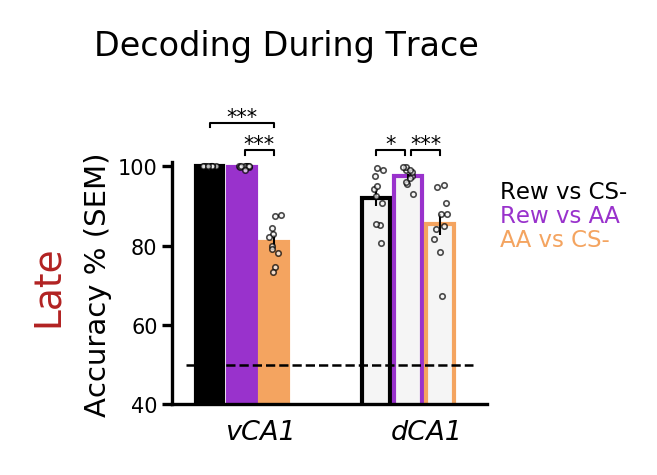

In [93]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
to_plot = [0,1]
t=6
tb='1s'
fig, ax = pl.subplots(figsize=(1.7,1.3))

for comp,c,la,wide in zip(['consumed_vs_run_CSm','consumed_vs_run_AA','run_CSm_vs_run_AA'],['k','darkorchid','sandybrown'],
                     ['Rew vs CS-','Rew vs AA','AA vs CS-'],[-width/3-.25,0,width/3+.25,0.5+.2]):
    ste = np.array(np.std(np.mean(eval("scores_gmins_%s_%s_%s_vhpc['post'][-loops:]"%(tb,t,comp)),1))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("scores_gmins_%s_%s_%s_vhpc['post'][-loops:]"%(tb,t,comp)))*100,
           width, edgecolor=c,color=c,yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, np.mean(eval("scores_gmins_%s_%s_%s_vhpc['post'][-loops:]"%(tb,t,comp)),1)*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
    
for comp,c,la,wide in zip(['consumed_vs_run_CSm','consumed_vs_run_AA','run_CSm_vs_run_AA'],['k','darkorchid','sandybrown'],
                     ['Rew vs CS-','Rew vs AA','AA vs CS-'],[1.8+-width/3-.25,1.8+0,1.8+width/3+.25,1.8+0.5+.2]):
    ste = np.array(np.std(np.mean(eval("scores_gmins_%s_%s_%s_dhpc['post'][-loops:]"%(tb,t,comp)),1))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("scores_gmins_%s_%s_%s_dhpc['post'][-loops:]"%(tb,t,comp)))*100,
           width, edgecolor=c,color='whitesmoke',yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, np.mean(eval("scores_gmins_%s_%s_%s_dhpc['post'][-loops:]"%(tb,t,comp)),1)*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,2.5, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)',labelpad=1.5)
#ax.set_title('Decoding During CS')
ax.set_ylim(40,101)
ax.set_xticks([0.2,2])
ax.set_xticklabels(labels,fontstyle='italic',fontsize=6.5)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.text(2.8,92,'Rew vs CS-',color='k',fontsize=5.5)
ax.text(2.8,86,'Rew vs AA',color='darkorchid',fontsize=5.5)
ax.text(2.8,80,'AA vs CS-',color='sandybrown',fontsize=5.5)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
test='ttest'
for reg,i in zip(['vhpc','dhpc'], [0,1.8]):
    pvs.append(add_significance(ax,np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),1),
                                np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
                                -width/3-.25+i,i-.03,104,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
                                np.mean(eval("scores_gmins_%s_%s_run_CSm_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
        i+.03,width/3+.25+i,104,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),1),
                                np.mean(eval("scores_gmins_%s_%s_run_CSm_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
        -width/3-.25+i,width/3+.25+i,111,sig_func=test,mcc=2))
    #print reg,'rw/sh',report_stats(eval("scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("scores_tb_4_sh_%s['post'][-loops:]"%reg),mcc=2)
    #print reg,'rw/CS-',report_stats(eval("scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=2)
    #print reg,'sh/CS-',report_stats(eval("scores_tb_4_sh_%s['post'][-loops:]"%reg), eval("scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=2)

pl.suptitle('Decoding During Trace',y=1.2,fontsize=8)
ax.text(-2.1,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_tr.jpg'%NOTEBOOK_NAME)

vhpc rwVCSm/AAVCSm U = 10.0 p = 0.00505256098616 r = -0.676123403783
None
vhpc rwVAA/AAVCSm U = 33.5 p = 0.339885945551 r = -0.27890090406
None
vhpc rwVCSm/rwVAA U = 90.0 p = 0.00345973585735 r = 0.676123403783
None
vhpc rwVCSm/AAVCSm U = 100.0 p = 0.000174899730734 r = 0.845154254729
None
vhpc rwVAA/AAVCSm U = 0.0 p = 0.000261858935641 r = -0.845154254729
None
vhpc rwVCSm/rwVAA U = 39.5 p = 0.556151373242 r = -0.177482393493
None


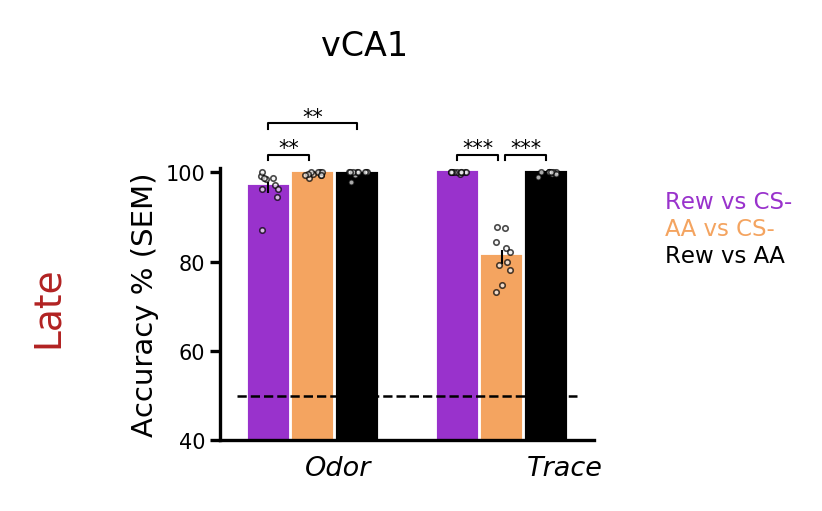

In [193]:
from matplotlib.patches import Patch
labels = ['Odor','Trace']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
to_plot = [0,1]
tb='1s'
fig, ax = pl.subplots(figsize=(1.9,1.4))

for comp,c,la,wide in zip(['consumed_vs_run_CSm','run_CSm_vs_run_AA','consumed_vs_run_AA'],['darkorchid','sandybrown','k'],
                     ['Rew vs CS-','AA vs CS-','Rew vs AA'],[-width/3-.25,0,width/3+.25,0.5+.2]):
    ste = np.array(np.std(np.mean(eval("scores_gmins_%s_3_%s_vhpc['post'][-loops:]"%(tb,comp)),1))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("scores_gmins_%s_3_%s_vhpc['post'][-loops:]"%(tb,comp)))*100,
           width, edgecolor=c,color=c,yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, np.mean(eval("scores_gmins_%s_3_%s_vhpc['post'][-loops:]"%(tb,comp)),1)*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
    
for comp,c,la,wide in zip(['consumed_vs_run_CSm','run_CSm_vs_run_AA','consumed_vs_run_AA'],['darkorchid','sandybrown','k'],
                     ['Rew vs CS-','AA vs CS-','Rew vs AA'],[1.5+-width/3-.25,1.5+0,1.5+width/3+.25,1.5+0.5+.2]):
    ste = np.array(np.std(np.mean(eval("scores_gmins_%s_6_%s_vhpc['post'][-loops:]"%(tb,comp)),1))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("scores_gmins_%s_6_%s_vhpc['post'][-loops:]"%(tb,comp)))*100,
           width, edgecolor=c,color=c,yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, np.mean(eval("scores_gmins_%s_6_%s_vhpc['post'][-loops:]"%(tb,comp)),1)*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,2.1, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)',labelpad=1.5)
#ax.set_title('Decoding During CS')
ax.set_ylim(40,101)
ax.set_xticks([0.2,2])
ax.set_xticklabels(labels,fontstyle='italic',fontsize=6.5)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.text(2.8,92,'Rew vs CS-',color='darkorchid',fontsize=5.5)
ax.text(2.8,80,'Rew vs AA',color='k',fontsize=5.5)
ax.text(2.8,86,'AA vs CS-',color='sandybrown',fontsize=5.5)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
test=None
reg='vhpc'
for t,i in zip([3,6], [0,1.5]):
    pvs.append(add_significance(ax,np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),1),
                                np.mean(eval("scores_gmins_%s_%s_run_CSm_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
                                -width/3-.25+i,i-.03,104,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,np.mean(eval("scores_gmins_%s_%s_run_CSm_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
                                np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
        i+.03,width/3+.25+i,104,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
                                np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),1),
        -width/3-.25+i,width/3+.25+i,111,sig_func=test,mcc=2))
    print reg,'rwVCSm/AAVCSm',report_stats(np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),1),
                                           np.mean(eval("scores_gmins_%s_%s_run_CSm_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),mcc=2)
    print reg,'rwVAA/AAVCSm',report_stats(np.mean(eval("scores_gmins_%s_%s_run_CSm_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
                                          np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),mcc=2)
    print reg,'rwVCSm/rwVAA',report_stats(np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
                                        np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),1),mcc=2)
pl.suptitle('vCA1',y=1.2,fontsize=8)
ax.text(-2.1,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_vhpc.pdf'%NOTEBOOK_NAME)

dhpc rwVCSm/AAVCSm U = 27.5 p = 0.190854899396 r = -0.380319414628
None
dhpc rwVAA/AAVCSm U = 29.0 p = 0.23177208043 r = -0.354964786986
None
dhpc rwVCSm/rwVAA U = 83.5 p = 0.0237756487191 r = 0.566253350668
None
dhpc rwVCSm/AAVCSm U = 74.5 p = 0.139074900074 r = 0.414125584817
None
dhpc rwVAA/AAVCSm U = 2.0 p = 0.000652868899803 r = -0.811348084539
None
dhpc rwVCSm/rwVAA U = 78.5 p = 0.0677777312879 r = 0.481737925195
None


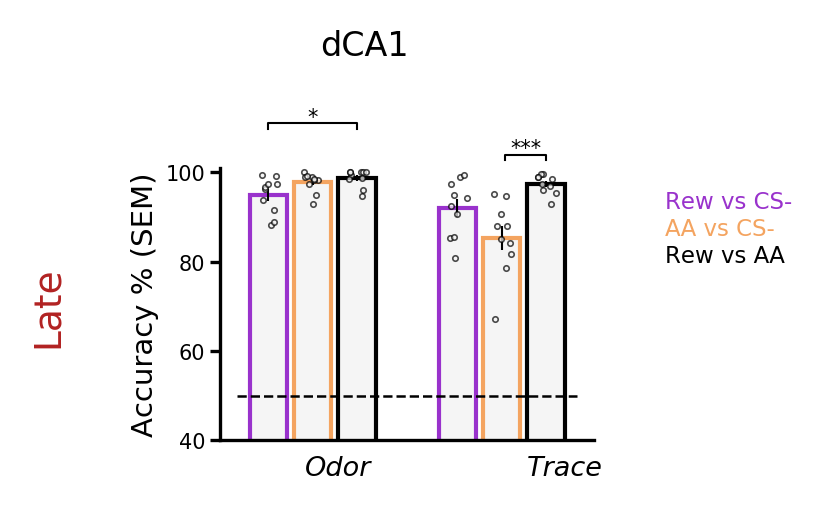

In [194]:
from matplotlib.patches import Patch
labels = ['Odor','Trace']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
to_plot = [0,1]
tb='1s'
fig, ax = pl.subplots(figsize=(1.9,1.4))

for comp,c,la,wide in zip(['consumed_vs_run_CSm','run_CSm_vs_run_AA','consumed_vs_run_AA'],['darkorchid','sandybrown','k'],
                     ['Rew vs CS-','AA vs CS-','Rew vs AA'],[-width/3-.25,0,width/3+.25,0.5+.2]):
    ste = np.array(np.std(np.mean(eval("scores_gmins_%s_3_%s_dhpc['post'][-loops:]"%(tb,comp)),1))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("scores_gmins_%s_3_%s_dhpc['post'][-loops:]"%(tb,comp)))*100,
           width, edgecolor=c,color='whitesmoke',yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, np.mean(eval("scores_gmins_%s_3_%s_dhpc['post'][-loops:]"%(tb,comp)),1)*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
    
for comp,c,la,wide in zip(['consumed_vs_run_CSm','run_CSm_vs_run_AA','consumed_vs_run_AA'],['darkorchid','sandybrown','k'],
                     ['Rew vs CS-','AA vs CS-','Rew vs AA'],[1.5+-width/3-.25,1.5+0,1.5+width/3+.25,1.5+0.5+.2]):
    ste = np.array(np.std(np.mean(eval("scores_gmins_%s_6_%s_dhpc['post'][-loops:]"%(tb,comp)),1))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("scores_gmins_%s_6_%s_dhpc['post'][-loops:]"%(tb,comp)))*100,
           width, edgecolor=c,color='whitesmoke',yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, np.mean(eval("scores_gmins_%s_6_%s_dhpc['post'][-loops:]"%(tb,comp)),1)*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,2.1, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)',labelpad=1.5)
#ax.set_title('Decoding During CS')
ax.set_ylim(40,101)
ax.set_xticks([0.2,2])
ax.set_xticklabels(labels,fontstyle='italic',fontsize=6.5)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.text(2.8,92,'Rew vs CS-',color='darkorchid',fontsize=5.5)
ax.text(2.8,80,'Rew vs AA',color='k',fontsize=5.5)
ax.text(2.8,86,'AA vs CS-',color='sandybrown',fontsize=5.5)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
test=None
reg='dhpc'
for t,i in zip([3,6], [0,1.5]):
    pvs.append(add_significance(ax,np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),1),
                                np.mean(eval("scores_gmins_%s_%s_run_CSm_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
                                -width/3-.25+i,i-.03,104,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,np.mean(eval("scores_gmins_%s_%s_run_CSm_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
                                np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
        i+.03,width/3+.25+i,104,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
                                np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),1),
        -width/3-.25+i,width/3+.25+i,111,sig_func=test,mcc=2))
    print reg,'rwVCSm/AAVCSm',report_stats(np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),1),
                                           np.mean(eval("scores_gmins_%s_%s_run_CSm_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),mcc=2)
    print reg,'rwVAA/AAVCSm',report_stats(np.mean(eval("scores_gmins_%s_%s_run_CSm_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
                                          np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),mcc=2)
    print reg,'rwVCSm/rwVAA',report_stats(np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
                                        np.mean(eval("scores_gmins_%s_%s_consumed_vs_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),1),mcc=2)

pl.suptitle('dCA1',y=1.2,fontsize=8)
ax.text(-2.1,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_bars_dhpc.pdf'%NOTEBOOK_NAME)

In [75]:
np.mean(scores_gmins_1s_6_run_CSm_vs_run_AA_vhpc['post'],1)

array([ 0.65  ,  0.775 ,  0.7025,  0.8475,  0.8325,  0.7975,  0.93  ,
        0.72  ,  0.82  ,  0.455 ,  0.8775,  0.7475,  0.8   ,  0.7325,
        0.83  ,  0.875 ,  0.7825,  0.7925,  0.845 ,  0.8225])

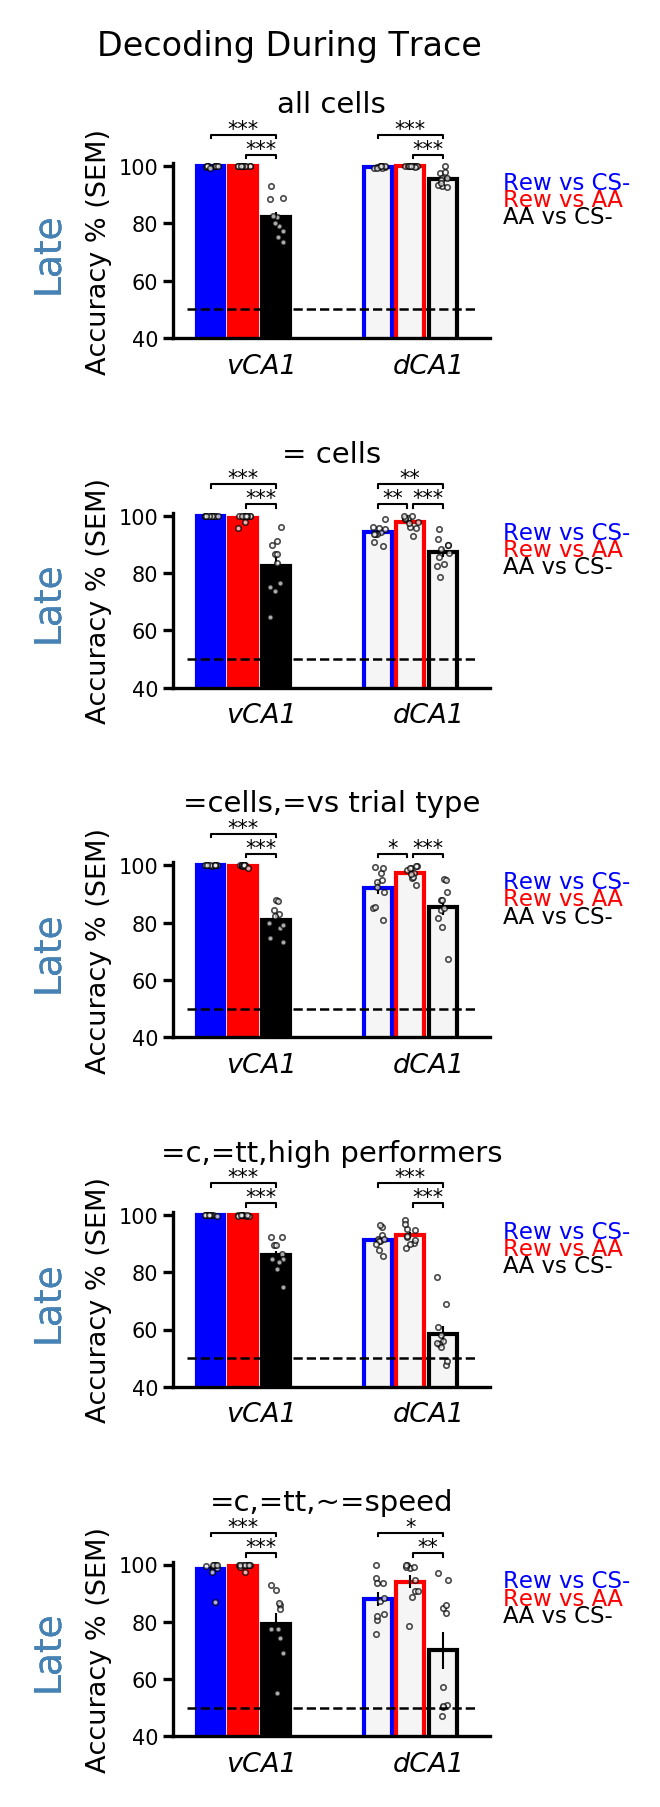

In [84]:
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
to_plot = [0,1]
t=6
tb='1s'
score_type = '','gmin_','gmins_','gmins_HP_','gmins_speed_'
fig, ax = pl.subplots(5,1,figsize=(1.7,6))

for x,s,l in zip(range(len(score_type)),score_type,['all cells','= cells','=cells,=vs trial type','=c,=tt,high performers','=c,=tt,~=speed']):
    for comp,c,la,wide in zip(['consumed_vs_run_CSm','consumed_vs_run_AA','run_CSm_vs_run_AA'],['b','r','k'],
                     ['Rew vs CS-','Rew vs AA','AA vs CS-'],[-width/3-.25,0,width/3+.25,0.5+.2]):
        ste = np.array(np.std(np.mean(eval("scores_%s%s_%s_%s_vhpc['post'][-loops:]"%(s,tb,t,comp)),1))*100/np.sqrt(loops-1))
        ax[x].bar(wide, np.mean(eval("scores_%s%s_%s_%s_vhpc['post'][-loops:]"%(s,tb,t,comp)))*100,
               width, edgecolor=c,color=c,yerr=ste)
        ax[x].scatter(wide+np.random.random(loops)*width/2-width/4.5, np.mean(eval("scores_%s%s_%s_%s_vhpc['post'][-loops:]"%(s,tb,t,comp)),1)*100,
                   color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
    

    for comp,c,la,wide in zip(['consumed_vs_run_CSm','consumed_vs_run_AA','run_CSm_vs_run_AA'],['b','r','k'],
                     ['Rew vs CS-','Rew vs AA','AA vs CS-'],[1.8+-width/3-.25,1.8+0,1.8+width/3+.25,1.8+0.5+.2]):
        ste = np.array(np.std(np.mean(eval("scores_%s%s_%s_%s_dhpc['post'][-loops:]"%(s,tb,t,comp)),1))*100/np.sqrt(loops-1))
        ax[x].bar(wide, np.mean(eval("scores_%s%s_%s_%s_dhpc['post'][-loops:]"%(s,tb,t,comp)))*100,
               width, edgecolor=c,color='whitesmoke',yerr=ste)
        ax[x].scatter(wide+np.random.random(loops)*width/2-width/4.5, np.mean(eval("scores_%s%s_%s_%s_dhpc['post'][-loops:]"%(s,tb,t,comp)),1)*100,
                   color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
        ax[x].set_title(l,y=1.15)
        ax[x].text(-2.1,70,'Late',rotation=90,fontsize=9,color='steelblue',ha='center',va='center')

    ax[x].hlines(50,-.6,2.5, color='k', lw=.6, linestyles='dashed')
    # [x]Add some text for labels, title and custom x-axis tick labels, etc.
    ax[x].set_ylabel('Accuracy % (SEM)',labelpad=1.5,fontsize=6.5)
    ax[x].set_ylim(40,101)
    ax[x].set_xticks([0.2,2])
    ax[x].set_xticklabels(labels,fontstyle='italic',fontsize=6.5)
    #a[x]x.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
    # [x]         ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
    ax[x].text(2.8,92,'Rew vs CS-',color='b',fontsize=5.5)
    ax[x].text(2.8,86,'Rew vs AA',color='r',fontsize=5.5)
    ax[x].text(2.8,80,'AA vs CS-',color='k',fontsize=5.5)
    ax[x].tick_params(axis='both',bottom=False,pad=1,length=2.5)
    pvs=[]
    test='ttest'
    for reg,i in zip(['vhpc','dhpc'], [0,1.8]):
        pvs.append(add_significance(ax[x],np.mean(eval("scores_%s%s_%s_consumed_vs_run_CSm_%s['post'][-loops:]"%(s,tb,t,reg)),1),
                                    np.mean(eval("scores_%s%s_%s_consumed_vs_run_AA_%s['post'][-loops:]"%(s,tb,t,reg)),1),
                                    -width/3-.25+i,i-.03,104,sig_func=test,mcc=2))
        pvs.append(add_significance(ax[x],np.mean(eval("scores_%s%s_%s_consumed_vs_run_AA_%s['post'][-loops:]"%(s,tb,t,reg)),1),
                                    np.mean(eval("scores_%s%s_%s_run_CSm_vs_run_AA_%s['post'][-loops:]"%(s,tb,t,reg)),1),
            i+.03,width/3+.25+i,104,sig_func=test,mcc=2))
        pvs.append(add_significance(ax[x],np.mean(eval("scores_%s%s_%s_consumed_vs_run_CSm_%s['post'][-loops:]"%(s,tb,t,reg)),1),
                                    np.mean(eval("scores_%s%s_%s_run_CSm_vs_run_AA_%s['post'][-loops:]"%(s,tb,t,reg)),1),
            -width/3-.25+i,width/3+.25+i,111,sig_func=test,mcc=2))
        #print reg,'rw/sh',report_stats(eval("scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("scores_tb_4_sh_%s['post'][-loops:]"%reg),mcc=2)
        #print reg,'rw/CS-',report_stats(eval("scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=2)
        #print reg,'sh/CS-',report_stats(eval("scores_tb_4_sh_%s['post'][-loops:]"%reg), eval("scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=2)

pl.suptitle('Decoding During Trace',y=1,fontsize=8)
fig.tight_layout(pad=2.5)

#fig.savefig('../figures/%s_bars_odor_RevLate.pdf'%NOTEBOOK_NAME)

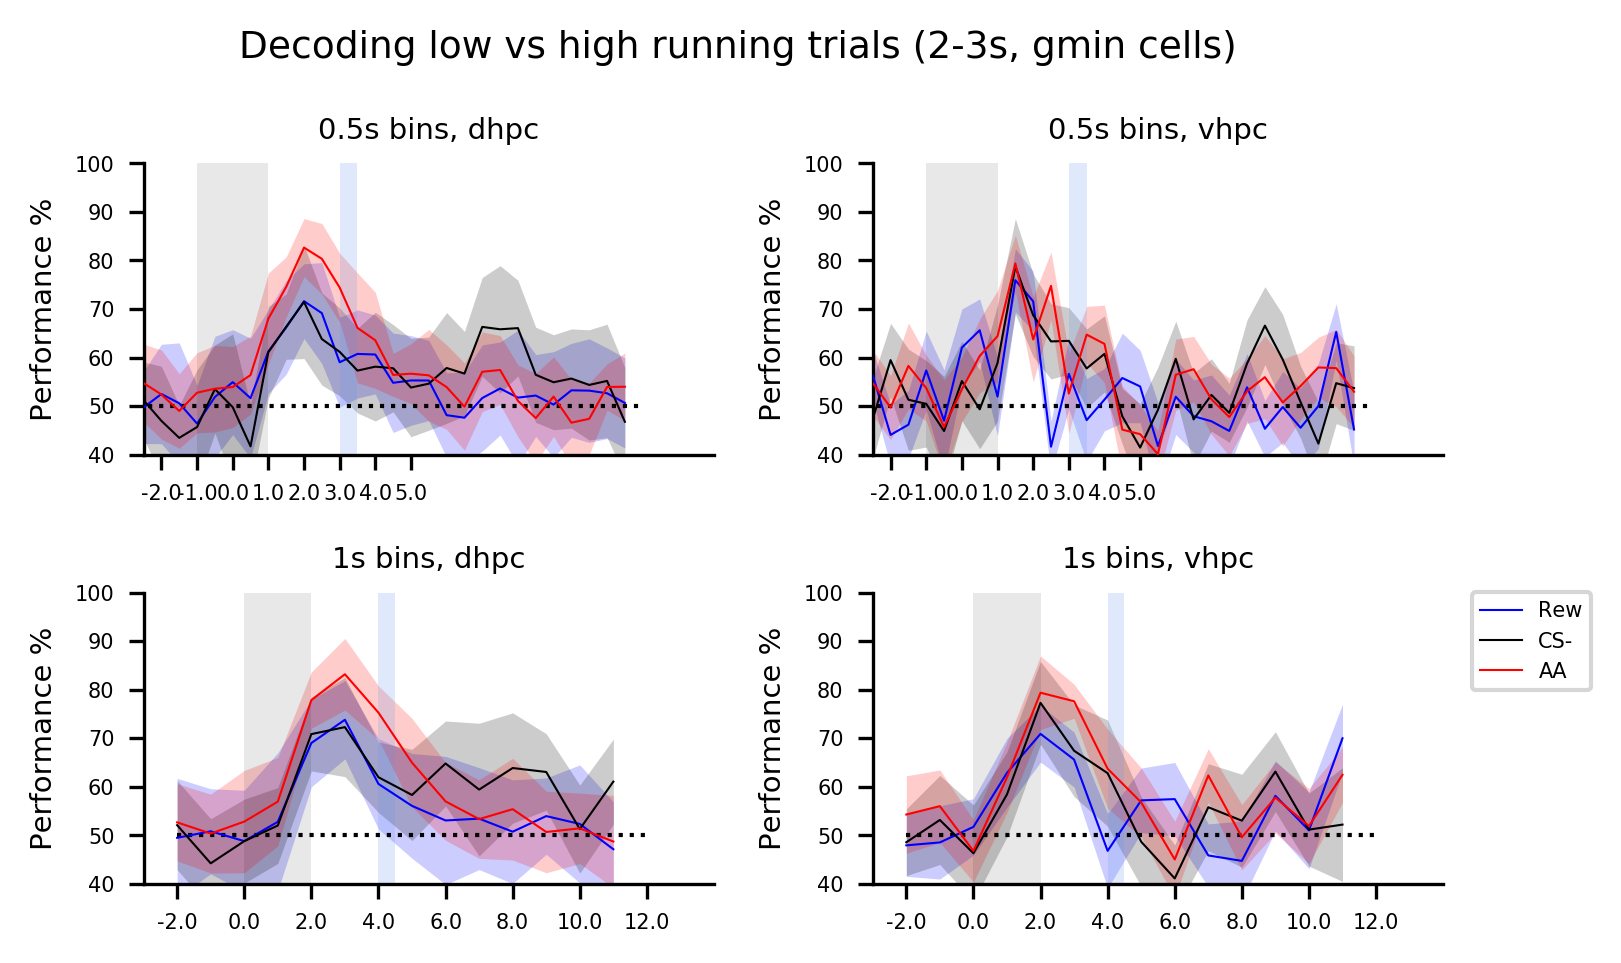

In [112]:
fig, ax = pl.subplots(2,2, figsize=(5,3))

for comp,c,la in zip(['consumed','run_CSm','run_AA'],['b','k','r'],
                     ['Rew','CS-','AA']):
    for r,tb,sub in zip(range(2),bins[:2],[4,2]):
        for y, reg in zip([0,1],['dhpc','vhpc']):
            ax[r][y].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("speed_scores_gmin_%s_%s_%s_%s['post']"%(tb,t,comp,reg)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("speed_scores_gmin_%s_%s_%s_%s['post']"%(tb,t,comp,reg)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(np.mean(eval("speed_scores_gmin_%s_%s_%s_%s['post']"%(tb,t,comp,reg)),1))*100 for t in range(bin_ranges[r])])
            ax[r][y].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x,tick in zip(range(2),[2,1]):
    for y,reg in zip([0,1],['dhpc','vhpc']):
        ax[x][y].set_ylim(40, 100)
        ax[x][y].set_xlim(-3, bin_ranges[x])
        ax[x][y].set_xticks(np.arange(-2,13, 2.0))
        ax[x][y].set_xticklabels(np.arange(-2,13*tick, 2.0/tick))
        ax[x][y].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
        #ax[x][y].set_xlabel('Time from odor onset (s)')
        ax[x][y].set_ylabel('Performance %')
        pt.plot_period_bar(ax[x][y], 0, start_end=(0, 2*tick), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[x][y], 0, start_end=(4*tick, 4.5*tick), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[x][y].tick_params(
        #axis='x',          # changes apply to the x-axis
        #which='both',      # both major and minor ticks are affected
        #bottom=False,      # ticks along the bottom edge are off
        #top=False,         # ticks along the top edge are off
        #labelbottom=False) # labels along the bottom edge are off
        ax[0][y].set_title('0.5s bins, %s'%reg, color='k')
        ax[1][y].set_title('1s bins, %s'%reg, color = 'k')
        ax[1][1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding low vs high running trials (2-3s, gmin cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#[y]fig.savefig('../figures/%s_run_gmins.jpg'%NOTEBOOK_NAME)

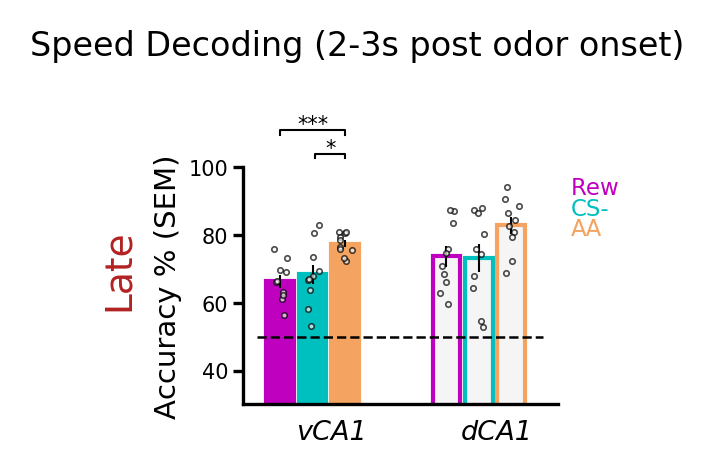

In [127]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
to_plot = [0,1]
t=5
tb='1s'
fig, ax = pl.subplots(figsize=(1.7,1.3))

for comp,c,la,wide in zip(['consumed','run_CSm','run_AA'],['m','c','sandybrown'],
                     ['Rew','CS-','AA'],[-width/3-.25,0,width/3+.25,0.5+.2]):
    ste = np.array(np.std(np.mean(eval("speed_scores_gmin_%s_%s_%s_vhpc['post'][-loops:]"%(tb,t,comp)),1))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("speed_scores_gmin_%s_%s_%s_vhpc['post'][-loops:]"%(tb,t,comp)))*100,
           width, edgecolor=c,color=c,yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, np.mean(eval("speed_scores_gmin_%s_%s_%s_vhpc['post'][-loops:]"%(tb,t,comp)),1)*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
    
for comp,c,la,wide in zip(['consumed','run_CSm','run_AA'],['m','c','sandybrown'],
                     ['Rew','CS-','AA'],[1.8+-width/3-.25,1.8+0,1.8+width/3+.25,1.8+0.5+.2]):
    ste = np.array(np.std(np.mean(eval("speed_scores_gmin_%s_%s_%s_dhpc['post'][-loops:]"%(tb,t,comp)),1))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("speed_scores_gmin_%s_%s_%s_dhpc['post'][-loops:]"%(tb,t,comp)))*100,
           width, edgecolor=c,color='whitesmoke',yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, np.mean(eval("speed_scores_gmin_%s_%s_%s_dhpc['post'][-loops:]"%(tb,t,comp)),1)*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,2.5, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)',labelpad=1.5)
#ax.set_title('Decoding During CS')
ax.set_ylim(30,100)
ax.set_xticks([0.2,2])
ax.set_xticklabels(labels,fontstyle='italic',fontsize=6.5)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.text(2.8,92,'Rew',color='m',fontsize=5.5)
ax.text(2.8,86,'CS-',color='c',fontsize=5.5)
ax.text(2.8,80,'AA',color='sandybrown',fontsize=5.5)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
test='ttest'
for reg,i in zip(['vhpc','dhpc'], [0,1.8]):
    pvs.append(add_significance(ax,np.mean(eval("speed_scores_gmin_%s_%s_consumed_%s['post'][-loops:]"%(tb,t,reg)),1),
                                np.mean(eval("speed_scores_gmin_%s_%s_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),1),
                                -width/3-.25+i,i-.03,104,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,np.mean(eval("speed_scores_gmin_%s_%s_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
                                np.mean(eval("speed_scores_gmin_%s_%s_run_CSm_%s['post'][-loops:]"%(tb,t,reg)),1),
        i+.03,width/3+.25+i,104,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,np.mean(eval("speed_scores_gmin_%s_%s_consumed_%s['post'][-loops:]"%(tb,t,reg)),1),
                                np.mean(eval("speed_scores_gmin_%s_%s_run_AA_%s['post'][-loops:]"%(tb,t,reg)),1),
        -width/3-.25+i,width/3+.25+i,111,sig_func=test,mcc=2))
    #print reg,'rw/sh',report_stats(eval("scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("scores_tb_4_sh_%s['post'][-loops:]"%reg),mcc=2)
    #print reg,'rw/CS-',report_stats(eval("scores_tb_4_rw_%s['post'][-loops:]"%reg), eval("scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=2)
    #print reg,'sh/CS-',report_stats(eval("scores_tb_4_sh_%s['post'][-loops:]"%reg), eval("scores_tb_4_csm_%s['post'][-loops:]"%reg),mcc=2)

pl.suptitle('Speed Decoding (2-3s post odor onset)',y=1.2,fontsize=8)
ax.text(-2.1,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
fig.tight_layout(pad=2.5)

#fig.savefig('../figures/%s_bars_tr.jpg'%NOTEBOOK_NAME)

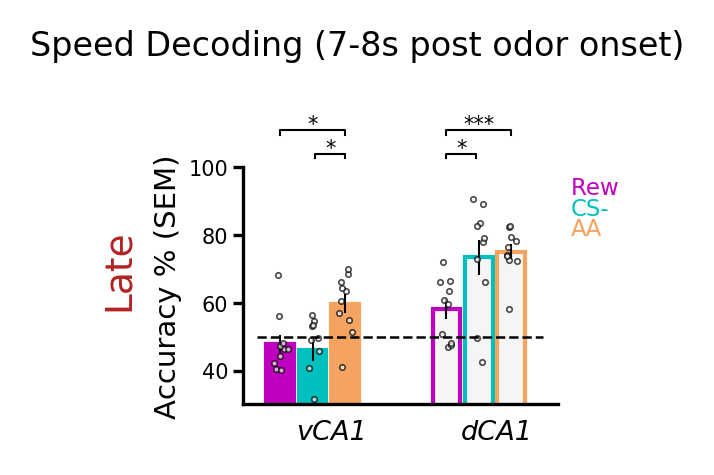

In [131]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars
loops=10
to_plot = [0,1]
t=10
tb='1s'
fig, ax = pl.subplots(figsize=(1.7,1.3))

for comp,c,la,wide in zip(['consumed','run_CSm','run_AA'],['m','c','sandybrown'],
                     ['Rew','CS-','AA'],[-width/3-.25,0,width/3+.25,0.5+.2]):
    ste = np.array(np.std(np.mean(eval("late_speed_scores_gmin_%s_%s_%s_vhpc['post'][:loops]"%(tb,t,comp)),1))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("late_speed_scores_gmin_%s_%s_%s_vhpc['post'][:loops]"%(tb,t,comp)))*100,
           width, edgecolor=c,color=c,yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, np.mean(eval("late_speed_scores_gmin_%s_%s_%s_vhpc['post'][:loops]"%(tb,t,comp)),1)*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
    
for comp,c,la,wide in zip(['consumed','run_CSm','run_AA'],['m','c','sandybrown'],
                     ['Rew','CS-','AA'],[1.8+-width/3-.25,1.8+0,1.8+width/3+.25,1.8+0.5+.2]):
    ste = np.array(np.std(np.mean(eval("late_speed_scores_gmin_%s_%s_%s_dhpc['post'][:loops]"%(tb,t,comp)),1))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("late_speed_scores_gmin_%s_%s_%s_dhpc['post'][:loops]"%(tb,t,comp)))*100,
           width, edgecolor=c,color='whitesmoke',yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, np.mean(eval("late_speed_scores_gmin_%s_%s_%s_dhpc['post'][:loops]"%(tb,t,comp)),1)*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,2.5, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)',labelpad=1.5)
#ax.set_title('Decoding During CS')
ax.set_ylim(30,100)
ax.set_xticks([0.2,2])
ax.set_xticklabels(labels,fontstyle='italic',fontsize=6.5)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.text(2.8,92,'Rew',color='m',fontsize=5.5)
ax.text(2.8,86,'CS-',color='c',fontsize=5.5)
ax.text(2.8,80,'AA',color='sandybrown',fontsize=5.5)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
test='ttest'
for reg,i in zip(['vhpc','dhpc'], [0,1.8]):
    pvs.append(add_significance(ax,np.mean(eval("late_speed_scores_gmin_%s_%s_consumed_%s['post'][:loops]"%(tb,t,reg)),1),
                                np.mean(eval("late_speed_scores_gmin_%s_%s_run_CSm_%s['post'][:loops]"%(tb,t,reg)),1),
                                -width/3-.25+i,i-.03,104,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,np.mean(eval("late_speed_scores_gmin_%s_%s_run_AA_%s['post'][:loops]"%(tb,t,reg)),1),
                                np.mean(eval("late_speed_scores_gmin_%s_%s_run_CSm_%s['post'][:loops]"%(tb,t,reg)),1),
        i+.03,width/3+.25+i,104,sig_func=test,mcc=2))
    pvs.append(add_significance(ax,np.mean(eval("late_speed_scores_gmin_%s_%s_consumed_%s['post'][:loops]"%(tb,t,reg)),1),
                                np.mean(eval("late_speed_scores_gmin_%s_%s_run_AA_%s['post'][:loops]"%(tb,t,reg)),1),
        -width/3-.25+i,width/3+.25+i,111,sig_func=test,mcc=2))
    #print reg,'rw/sh',report_stats(eval("scores_tb_4_rw_%s['post'][:loops]"%reg), eval("scores_tb_4_sh_%s['post'][:loops]"%reg),mcc=2)
    #print reg,'rw/CS-',report_stats(eval("scores_tb_4_rw_%s['post'][:loops]"%reg), eval("scores_tb_4_csm_%s['post'][:loops]"%reg),mcc=2)
    #print reg,'sh/CS-',report_stats(eval("scores_tb_4_sh_%s['post'][:loops]"%reg), eval("scores_tb_4_csm_%s['post'][:loops]"%reg),mcc=2)

pl.suptitle('Speed Decoding (7-8s post odor onset)',y=1.2,fontsize=8)
ax.text(-2.1,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
fig.tight_layout(pad=2.5)

#fig.savefig('../figures/%s_bars_tr.jpg'%NOTEBOOK_NAME)

In [149]:
print len(combined_late_speed_scores_gmin_1s_10_dhpc['post'])

60


In [145]:
speed_comparisons='consumed','run_CSm','run_AA'
for tb,i in zip(bins,range(len(bins))):
    for t in range(bin_ranges[i]): # number of time bins
        for reg in 'dhpc','vhpc':
            exec('combined_late_speed_scores_gmin_%s_%s_%s = {}'%(tb,t,reg))
            exec("combined_late_speed_scores_gmin_%s_%s_%s['post']=[]"%(tb,t,reg))
            for comp in speed_comparisons:
                exec("combined_late_speed_scores_gmin_%s_%s_%s['post'].extend(late_speed_scores_gmin_%s_%s_%s_%s['post'])"%(tb,t,reg,tb,t,comp,reg))

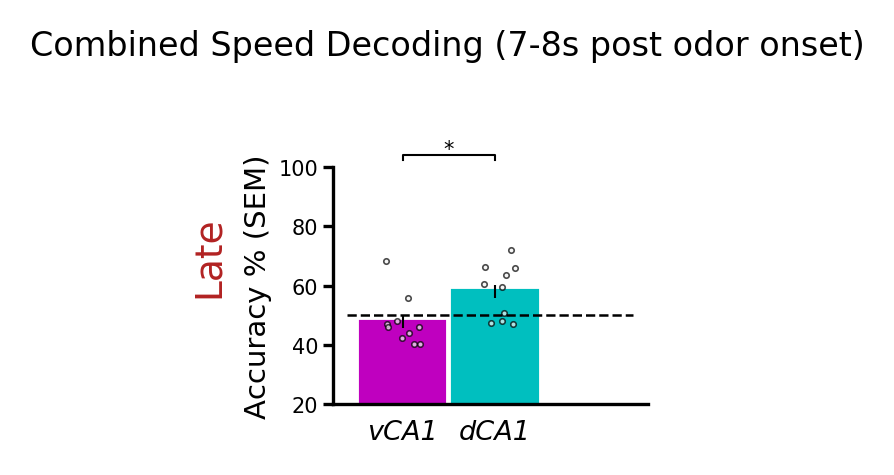

In [310]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = .9# the width of the bars
loops=10
to_plot = [0,1]
t=10
tb='1s'
fig, ax = pl.subplots(figsize=(1.7,1.3))

for reg,c,la,wide in zip(['vhpc','dhpc'],['m','c'],labels,[0,1]):
    ste_v = np.array(np.std(np.mean(eval("combined_late_speed_scores_gmin_%s_%s_vhpc['post'][:loops]"%(tb,t)),1))*100/np.sqrt(loops-1))
    ste_d = np.array(np.std(np.mean(eval("combined_late_speed_scores_gmin_%s_%s_dhpc['post'][:loops]"%(tb,t)),1))*100/np.sqrt(loops-1))
    ax.bar(wide, np.mean(eval("combined_late_speed_scores_gmin_%s_%s_%s['post'][:loops]"%(tb,t,reg)))*100,width, edgecolor=c,color=c,yerr=ste)
    ax.scatter(wide+np.random.random(loops)*width/2-width/4.5, np.mean(eval("combined_late_speed_scores_gmin_%s_%s_%s['post'][:loops]"%(tb,t,reg)),1)*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,2.5, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy % (SEM)',labelpad=1.5)
#ax.set_title('Decoding During CS')
ax.set_ylim(20,100)
ax.set_xticks([0,1])
ax.set_xticklabels(labels,fontstyle='italic',fontsize=6.5)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
test='ttest'
pvs.append(add_significance(ax,np.mean(eval("combined_late_speed_scores_gmin_%s_%s_vhpc['post'][:loops]"%(tb,t)),1),
                                np.mean(eval("combined_late_speed_scores_gmin_%s_%s_dhpc['post'][:loops]"%(tb,t)),1),
                                0,1,104,sig_func=test,mcc=2))
    #print reg,'rw/sh',report_stats(eval("scores_tb_4_rw_%s['post'][:loops]"%reg), eval("scores_tb_4_sh_%s['post'][:loops]"%reg),mcc=2)
    #print reg,'rw/CS-',report_stats(eval("scores_tb_4_rw_%s['post'][:loops]"%reg), eval("scores_tb_4_csm_%s['post'][:loops]"%reg),mcc=2)
    #print reg,'sh/CS-',report_stats(eval("scores_tb_4_sh_%s['post'][:loops]"%reg), eval("scores_tb_4_csm_%s['post'][:loops]"%reg),mcc=2)

pl.suptitle('Combined Speed Decoding (7-8s post odor onset)',y=1.2,fontsize=8)
ax.text(-2.1,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
fig.tight_layout(pad=2.5)

#fig.savefig('../figures/%s_bars_tr.jpg'%NOTEBOOK_NAME)

In [197]:
bins

['05s', '1s', '2s']

In [198]:
#now get average of all speed decoding scores for bins 5-10s post CS onset (ie, bins outside of task)
speed_comparisons='consumed','run_CSm','run_AA'
for tb,i in zip(bins[:2],range(len(bins[:2]))):
    for reg in 'dhpc','vhpc':
        exec('combined_5thru10s_late_speed_scores_gmin_%s_%s = {}'%(tb,reg))
        exec("combined_5thru10s_late_speed_scores_gmin_%s_%s['post']=[]"%(tb,reg))
        for t in (range(8,13)): #bins running through 5-10s post odor
            for comp in speed_comparisons:
                exec("combined_5thru10s_late_speed_scores_gmin_%s_%s['post'].extend(late_speed_scores_gmin_%s_%s_%s_%s['post'])"%(tb,reg,tb,t,comp,reg))

In [225]:
np.mean(combined_5thru10s_late_speed_scores_gmin_1s_dhpc['post'])

0.61347499999999999

In [312]:
np.mean(late_speed_scores_gmin_05s_10_run_AA_vhpc['post'],0)

array([ 0.57625,  0.593  ])

In [321]:
#now get average of all speed decoding scores for bins 5-10s post CS onset (ie, bins outside of task)
speed_comparisons='consumed','run_CSm','run_AA'
for tb,i in zip(bins[:2],range(len(bins[:2]))):
    for reg in 'dhpc','vhpc':
        exec('mean_combined_5thru10s_late_speed_scores_gmin_%s_%s = {}'%(tb,reg))
        exec("mean_combined_5thru10s_late_speed_scores_gmin_%s_%s['post']=[]"%(tb,reg))
        for t in (range(8,13)): #bins running through 5-10s post odor
            for comp in speed_comparisons:
                print t,comp,
                exec("mean_combined_5thru10s_late_speed_scores_gmin_%s_%s['post'].extend([np.mean(late_speed_scores_gmin_%s_%s_%s_%s['post'])])"%(tb,reg,tb,t,comp,reg))

8 consumed 8 run_CSm 8 run_AA 9 consumed 9 run_CSm 9 run_AA 10 consumed 10 run_CSm 10 run_AA 11 consumed 11 run_CSm 11 run_AA 12 consumed 12 run_CSm 12 run_AA 8 consumed 8 run_CSm 8 run_AA 9 consumed 9 run_CSm 9 run_AA 10 consumed 10 run_CSm 10 run_AA 11 consumed 11 run_CSm 11 run_AA 12 consumed 12 run_CSm 12 run_AA 8 consumed 8 run_CSm 8 run_AA 9 consumed 9 run_CSm 9 run_AA 10 consumed 10 run_CSm 10 run_AA 11 consumed 11 run_CSm 11 run_AA 12 consumed 12 run_CSm 12 run_AA 8 consumed 8 run_CSm 8 run_AA 9 consumed 9 run_CSm 9 run_AA 10 consumed 10 run_CSm 10 run_AA 11 consumed 11 run_CSm 11 run_AA 12 consumed 12 run_CSm 12 run_AA


In [318]:
#now get average of all speed decoding scores for bins 5-10s post CS onset (ie, bins outside of task)
speed_comparisons='consumed','run_CSm','run_AA'
for tb,i in zip(bins[:2],range(len(bins[:2]))):
    for reg in 'dhpc','vhpc':
        exec('mean_combined_5thru10s_late_speed_scores_gmin_%s_%s = {}'%(tb,reg))
        exec("mean_combined_5thru10s_late_speed_scores_gmin_%s_%s['post']=[]"%(tb,reg))
        for t in (range(8,13)): #bins running through 5-10s post odor
            for comp in speed_comparisons:
                print t,comp,
                exec("mean_combined_5thru10s_late_speed_scores_gmin_%s_%s['post'].extend([np.mean(late_speed_scores_gmin_%s_%s_%s_%s['post'],0)])"%(tb,reg,tb,t,comp,reg))

8 consumed 8 run_CSm 8 run_AA 9 consumed 9 run_CSm 9 run_AA 10 consumed 10 run_CSm 10 run_AA 11 consumed 11 run_CSm 11 run_AA 12 consumed 12 run_CSm 12 run_AA 8 consumed 8 run_CSm 8 run_AA 9 consumed 9 run_CSm 9 run_AA 10 consumed 10 run_CSm 10 run_AA 11 consumed 11 run_CSm 11 run_AA 12 consumed 12 run_CSm 12 run_AA 8 consumed 8 run_CSm 8 run_AA 9 consumed 9 run_CSm 9 run_AA 10 consumed 10 run_CSm 10 run_AA 11 consumed 11 run_CSm 11 run_AA 12 consumed 12 run_CSm 12 run_AA 8 consumed 8 run_CSm 8 run_AA 9 consumed 9 run_CSm 9 run_AA 10 consumed 10 run_CSm 10 run_AA 11 consumed 11 run_CSm 11 run_AA 12 consumed 12 run_CSm 12 run_AA


In [322]:
(np.array(eval("mean_combined_5thru10s_late_speed_scores_gmin_%s_%s['post']"%(tb,reg)))*100)

array([ 47.8375,  59.3125,  52.5625,  49.3125,  67.1625,  65.125 ,
        48.2375,  46.    ,  62.625 ,  66.5875,  49.875 ,  58.7625,
        60.4625,  57.4   ,  55.175 ])

U = 75.5 p = 0.129995937943 r = 0.431028669912
None
vCA1 v chance: WilcoxonResult(statistic=16.0, pvalue=0.012453304046185139) r = -0.574704893215
None
dCA1 v chance: WilcoxonResult(statistic=2.0, pvalue=0.00098709743887923085) r = -0.811348084539
None


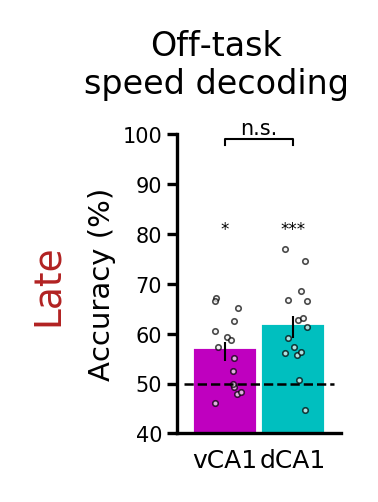

In [327]:
from matplotlib.patches import Patch
labels = ['vCA1','dCA1']
x = np.arange(len(labels))  # the label locations
width = .85 # the width of the bars
to_plot = [0,1]
t=10
tb='1s'
fig, ax = pl.subplots(figsize=(1.2,1.5))

for reg,c,la,wide in zip(['vhpc','dhpc'],['m','c'],labels,[0,1]):
    ste = np.array(np.std(eval("mean_combined_5thru10s_late_speed_scores_gmin_%s_%s['post']"%(tb,reg)))*100/np.sqrt(15-1))
    ax.bar(wide, np.mean(eval("mean_combined_5thru10s_late_speed_scores_gmin_%s_%s['post']"%(tb,reg)))*100,width, edgecolor=c,color=c,yerr=ste)
    ax.scatter(wide+np.random.random(15)*width/2-width/4.5, np.array(eval("mean_combined_5thru10s_late_speed_scores_gmin_%s_%s['post']"%(tb,reg)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')

ax.hlines(50,-.6,1.6, color='k', lw=.6, linestyles='dashed')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)',labelpad=1.5)
#ax.set_title('Decoding During CS')
ax.set_ylim(40,100)
ax.set_xticks([0,1])
ax.set_xticklabels(labels,fontsize=6)
#ax.legend([Patch(facecolor='darkorchid'),Patch(facecolor='sandybrown'),Patch(facecolor='darkturquoise')],
#          ['Rew','Shock','CS-'],loc=(.95,.6),frameon=False)
ax.tick_params(axis='both',bottom=False,pad=1,length=2.5)
pvs=[]
test='ttest'
pvs.append(add_significance(ax,eval("mean_combined_5thru10s_late_speed_scores_gmin_%s_vhpc['post']"%(tb)),
                                eval("mean_combined_5thru10s_late_speed_scores_gmin_%s_dhpc['post']"%(tb)),
                                0,1,99,sig_func=test,mcc=1,suppress_ns=False))
pvs.append(sig_vs_chance(ax,eval("mean_combined_5thru10s_late_speed_scores_gmin_%s_vhpc['post']"%(tb)),0.5,0,80,loops=15))
pvs.append(sig_vs_chance(ax,eval("mean_combined_5thru10s_late_speed_scores_gmin_%s_dhpc['post']"%(tb)),0.5,1,80,loops=15))
print report_stats(eval("mean_combined_5thru10s_late_speed_scores_gmin_%s_vhpc['post']"%(tb)),
                    eval("mean_combined_5thru10s_late_speed_scores_gmin_%s_dhpc['post']"%(tb)),mcc=1)
print 'vCA1 v chance:',report_stats_chance(eval("mean_combined_5thru10s_late_speed_scores_gmin_%s_vhpc['post']"%(tb)),chance=0.5)
print 'dCA1 v chance:',report_stats_chance(eval("mean_combined_5thru10s_late_speed_scores_gmin_%s_dhpc['post']"%(tb)),chance=0.5)

pl.suptitle('Off-task\nspeed decoding',y=1.1,fontsize=8)
ax.text(-2.6,70,'Late',rotation=90,fontsize=9,color='firebrick',ha='center',va='center')
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_post_task_speed_decoding_dv.pdf'%NOTEBOOK_NAME)

In [41]:
save_workspace(db)

Could not store variable 'IPython'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'np'. Skipping...
